# Self-implemented Tabnet on Forest Coverage Dataset
An evaluation of a tabnet on the Forest Coverage Dataset. Parameters taken from Tabnet paper. A simple 3 layers NN scores an accuracy of 95%, compared with a tabnet score of.

In [222]:
%load_ext autoreload
%autoreload 2

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from utils import accuracy, count_parameters
from tabnet import TabNet
import seaborn as sn

In [261]:
p = Path.cwd() / "data" / "ForestCoverage" / "covtype.csv"

In [262]:
df = pd.read_csv(p)

In [263]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [286]:
df.shape

(581012, 55)

In [264]:
labels = df["Cover_Type"].values - 1
features = df.drop("Cover_Type", axis=1)

In [265]:
v, c = np.unique(labels, return_counts=True)
for value, count in zip(v, c):
    print(f"{value}, {count * 100 / len(labels):.2f}%")

0, 36.46%
1, 48.76%
2, 6.15%
3, 0.47%
4, 1.63%
5, 2.99%
6, 3.53%


In [266]:
st = features.iloc[:, 14:].values
num = features.iloc[:, :14].values

In [267]:
st_labels = st.argmax(axis=1)

In [268]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [269]:
for train_index, test_index in splitter.split(num, labels):
    X_train, Xl_train, X_test, Xl_test = num[train_index], st_labels[train_index], num[test_index], st_labels[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [270]:
class CoverageDS(Dataset):
    def __init__(self, X, Xem, y):
        super().__init__()
        self.X = torch.from_numpy(X)
        self.Xem = torch.from_numpy(Xem)
        self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.Xem[idx], self.y[idx]

In [271]:
BS = 512

In [272]:
train = DataLoader(CoverageDS(X_train, Xl_train, y_train), batch_size = BS, shuffle=True, drop_last=False)
test = DataLoader(CoverageDS(X_test, Xl_test, y_test), batch_size = BS, shuffle=False, drop_last=False)

In [274]:
class Model(nn.Module):
    def __init__(self, n_in, n_em, size, em_size, n_o):
        super().__init__()
        self.em = nn.Embedding(n_em, em_size)
        self.bn1 = nn.BatchNorm1d(n_in + em_size)
        self.do1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(n_in + em_size, size)
        
        self.bn2 = nn.BatchNorm1d(size)
        self.do2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(size, size)
        
        self.bn3 = nn.BatchNorm1d(size)
        self.do3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(size, n_o)
        
    def forward(self, x, xem):
        x = torch.cat((x, self.em(xem)), axis=1)
        x = F.relu(self.fc1((self.bn1(x))))
        x = F.relu(self.fc2((self.bn2(x))))
        x = self.fc3((self.bn3(x)))
        return x

In [275]:
model = Model(X_train.shape[1], Xl_train.max() + 1, 256, 4, y_train.max() + 1)
opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)
sched  = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=3, eps=1e-6, verbose=True)
crit = nn.CrossEntropyLoss()

In [276]:
count_parameters(model)

Total Trainable Params: 73675


73675

In [277]:
def train_epoch(net, train, val, crit, opt, metric):
    losses = []
    accs = []
    for X, Xem, y in train:
        opt.zero_grad()
        net.train()
        p = net(X, Xem)
        accs.append(metric(y, p))
        loss = crit(p, y)
        losses.append(loss.item())
        loss.backward()
        opt.step()
    with torch.no_grad():
        net.eval()
        val_loss = []
        val_acc = []
        for X, Xem, y in val:
            p = net(X, Xem)
            val_loss.append(crit(p, y).item())
            val_acc.append(metric(y, p))
    return np.mean(losses), np.mean(accs), np.mean(val_loss), np.mean(val_acc)

In [278]:
N_EPOCHS = 50
for epoch in range(N_EPOCHS):
    tl, ta, vl, va = train_epoch(model, train, test, crit, opt, accuracy)
    sched.step(vl)
    print(f"Epoch:{epoch + 1}, T Loss:{tl:.5f}, T Met:{ta:.5f}, V Loss:{vl:.5f}, V Met:{va:.5f}")

Epoch:1, T Loss:0.49412, T Met:0.79244, V Loss:0.37885, V Met:0.84256
Epoch:2, T Loss:0.36513, T Met:0.84784, V Loss:0.33156, V Met:0.86307
Epoch:3, T Loss:0.32520, T Met:0.86580, V Loss:0.30144, V Met:0.87691
Epoch:4, T Loss:0.30460, T Met:0.87476, V Loss:0.31296, V Met:0.86887
Epoch:5, T Loss:0.29100, T Met:0.88103, V Loss:0.27203, V Met:0.89059
Epoch:6, T Loss:0.27946, T Met:0.88500, V Loss:0.27225, V Met:0.88744
Epoch:7, T Loss:0.27400, T Met:0.88742, V Loss:0.26641, V Met:0.89010
Epoch:8, T Loss:0.26748, T Met:0.89028, V Loss:0.26029, V Met:0.89549
Epoch:9, T Loss:0.26283, T Met:0.89275, V Loss:0.24952, V Met:0.89925
Epoch:10, T Loss:0.25995, T Met:0.89324, V Loss:0.25091, V Met:0.89817
Epoch:11, T Loss:0.25606, T Met:0.89476, V Loss:0.25072, V Met:0.89698
Epoch:12, T Loss:0.25419, T Met:0.89591, V Loss:0.24619, V Met:0.90105
Epoch:13, T Loss:0.25090, T Met:0.89722, V Loss:0.23308, V Met:0.90425
Epoch:14, T Loss:0.24937, T Met:0.89800, V Loss:0.23510, V Met:0.90511
Epoch:15, T Los

In [279]:
def plot_cm(model, test):
    all_preds = []
    with torch.no_grad():
        for x, xem, y in test:
            p = model(x, xem)
            preds = np.argmax(p, axis=1)
            all_preds.append(preds)
    all_preds = torch.cat(all_preds)
    cm = confusion_matrix(y_test, all_preds.detach().numpy()).astype("float32")
    cm = (cm / cm.sum(axis=1).reshape(-1, 1)) * 100
    plt.figure(figsize=(15, 8))
    sn.heatmap(cm, annot=True, annot_kws={"size": 16})
    plt.show()

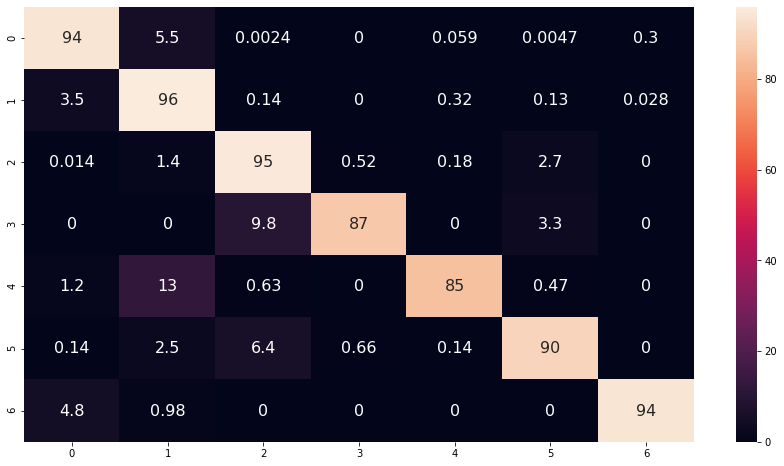

In [280]:
plot_cm(model, test)

In [281]:
class Tmodel(nn.Module):
    def __init__(self, n_in, n_em, em_size, n_o):
        super().__init__()
        self.em = nn.Embedding(n_em, em_size)
        self.tabnet = TabNet(
            n_in + em_size,
            n_o,
            na=64,
            nd=64,
            n_steps=5,
            n_blocks=4,
            n_shared_blocks=2,
            shared_mask=False,
            relax=1.5,
            ghost_size=512,
            sparsemax=True,
            )
        
    def forward(self, x, xem):
        x = torch.cat((x, self.em(xem)), axis=1)
        return self.tabnet(x)

In [282]:
tmodel = Tmodel(X_train.shape[1], Xl_train.max() + 1, 4, y_train.max() + 1)
BS = 16384
topt = optim.Adam(tmodel.parameters(), lr=0.02, weight_decay=0.0)
tsched  = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, eps=1e-7, verbose=True)

In [283]:
count_parameters(tmodel)

Total Trainable Params: 46655


46655

In [284]:
train = DataLoader(CoverageDS(X_train, Xl_train, y_train), batch_size = BS, shuffle=True, drop_last=False)
test = DataLoader(CoverageDS(X_test, Xl_test, y_test), batch_size = BS, shuffle=False, drop_last=False)

In [285]:
N_EPOCHS = 50
vls = []
for epoch in range(N_EPOCHS):
    tl, ta, vl, va = train_epoch(tmodel, train, test, crit, topt, accuracy)
    tsched.step(vl)
    vls.append(vl)
    print(f"Epoch:{epoch + 1}, T Loss:{tl:.5f}, T Met:{ta:.5f}, V Loss:{vl:.5f}, V Met:{va:.5f}")

Epoch:1, T Loss:1.11792, T Met:0.60721, V Loss:0.94891, V Met:0.58970
Epoch:2, T Loss:0.73630, T Met:0.68787, V Loss:0.70529, V Met:0.70096
Epoch:3, T Loss:0.69195, T Met:0.70226, V Loss:0.68431, V Met:0.70413
Epoch:4, T Loss:0.68319, T Met:0.70246, V Loss:0.67331, V Met:0.70597
Epoch:5, T Loss:0.67567, T Met:0.70445, V Loss:0.67998, V Met:0.70514
Epoch:6, T Loss:0.67901, T Met:0.70582, V Loss:0.66731, V Met:0.71353
Epoch:7, T Loss:0.66413, T Met:0.71259, V Loss:0.65358, V Met:0.71606
Epoch:8, T Loss:0.65504, T Met:0.71566, V Loss:0.64398, V Met:0.71886
Epoch:9, T Loss:0.64509, T Met:0.71948, V Loss:0.63676, V Met:0.72281
Epoch:10, T Loss:0.63340, T Met:0.72443, V Loss:0.62570, V Met:0.72550
Epoch:11, T Loss:0.62227, T Met:0.72753, V Loss:0.61395, V Met:0.73035
Epoch:12, T Loss:0.63121, T Met:0.72502, V Loss:0.65074, V Met:0.71539
Epoch:13, T Loss:0.65599, T Met:0.71495, V Loss:0.64620, V Met:0.71950
Epoch:14, T Loss:0.64011, T Met:0.72095, V Loss:0.63418, V Met:0.72255
Epoch    15: re